In [11]:
import torch
import numpy as np
import torch.nn as nn
from scipy.io import loadmat
import matplotlib.pyplot as plt
from Dataset import Dataset, ELM, device
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [12]:
train = loadmat('data_training_reactor_pol.mat')
test = loadmat('data_validation_reactor_pol.mat')

y_train = 0.0001*(train['NAMW'][0]-train['NAMW'][0][0])
y_test = 0.0001*(test['NAMW'][0]-test['NAMW'][0][0])

x_train = np.concatenate((100*np.concatenate(([[0]], (train['FI'].T[1:]-train['FI'].T[0])), axis=0),
                          100*np.concatenate(([[0], [0]], (train['FI'].T[2:]-train['FI'].T[0])), axis=0),
                          np.concatenate(([0], y_train[1:]), axis=0).reshape(-1, 1),
                          np.concatenate(([0, 0], y_train[2:]), axis=0).reshape(-1, 1)), axis=1)

x_test = np.concatenate((100*np.concatenate(([[0]], (test['FI'].T[1:]-test['FI'].T[0])), axis=0),
                         100*np.concatenate(([[0], [0]], (test['FI'].T[2:]-test['FI'].T[0])), axis=0),
                         np.concatenate(([0], y_test[1:]), axis=0).reshape(-1, 1),
                         np.concatenate(([0, 0], y_test[2:]), axis=0).reshape(-1, 1)), axis=1)

intersize = 400

x_inter = x_test[0:intersize]
y_inter = y_test[0:intersize]

x_test = x_test[intersize:]
y_test = y_test[intersize:]

In [13]:
trainset = Dataset(x_train, y_train)
testset = Dataset(x_test, y_test)
interset = Dataset(x_inter, y_inter)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

activation = nn.Sigmoid()

In [14]:
# model = ELM(4, intersize, 1).to(device)

# V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ interset[:][0].T.to(device))
# H = torch.concatenate([torch.ones(1, len(interset)).to(device), V.to(device)], dim=0).T
# T = interset[:][1].reshape(1, -1).T.to(device)
# W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
# model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

1
2
3
4
5
6
7
8
9
10


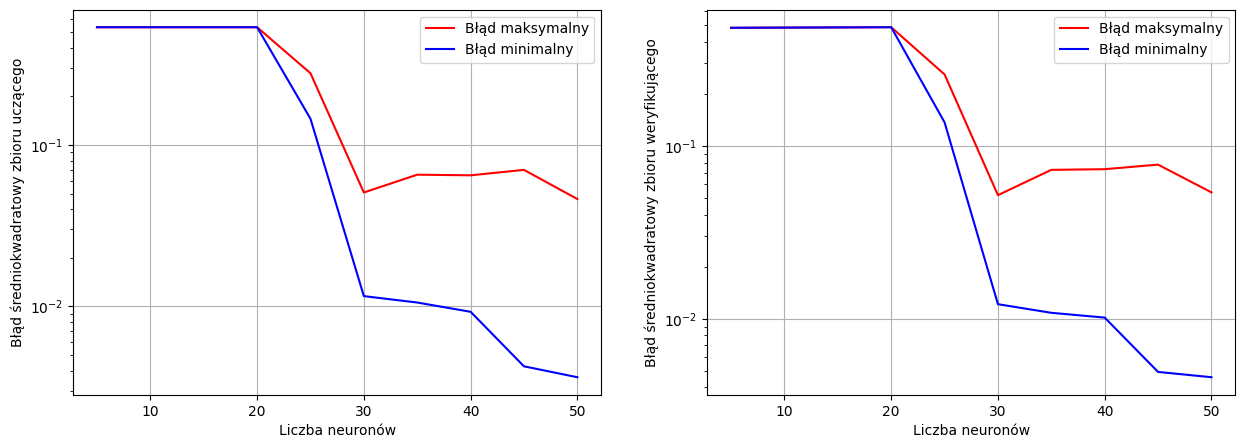

4.82e-1 & 4.83e-1 & 4.58e-3 & 

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
max_train_error = []
min_train_error = []
max_test_error = []
min_test_error = []
num_neurons = 200
for j in range(1, num_neurons+1):
    print(j)
    train_error = []
    test_error = []
    for i in range(10):
        model = ELM(4, 5*j, 1).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-9)
        intersize = 5*j

        train = loadmat('data_training_reactor_pol.mat')
        test = loadmat('data_validation_reactor_pol.mat')

        y_train = 0.0001*(train['NAMW'][0]-train['NAMW'][0][0])
        y_test = 0.0001*(test['NAMW'][0]-test['NAMW'][0][0])

        x_train = np.concatenate((100*np.concatenate(([[0]], (train['FI'].T[1:]-train['FI'].T[0])), axis=0),
                                100*np.concatenate(([[0], [0]], (train['FI'].T[2:]-train['FI'].T[0])), axis=0),
                                np.concatenate(([0], y_train[1:]), axis=0).reshape(-1, 1),
                                np.concatenate(([0, 0], y_train[2:]), axis=0).reshape(-1, 1)), axis=1)

        x_test = np.concatenate((100*np.concatenate(([[0]], (test['FI'].T[1:]-test['FI'].T[0])), axis=0),
                                100*np.concatenate(([[0], [0]], (test['FI'].T[2:]-test['FI'].T[0])), axis=0),
                                np.concatenate(([0], y_test[1:]), axis=0).reshape(-1, 1),
                                np.concatenate(([0, 0], y_test[2:]), axis=0).reshape(-1, 1)), axis=1)

        x_inter = x_test[0:intersize]
        y_inter = y_test[0:intersize]

        x_test = x_test[intersize:]
        y_test = y_test[intersize:]

        testset = Dataset(x_test, y_test)
        interset = Dataset(x_inter, y_inter)

        trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
        testloader = DataLoader(testset, batch_size=128, shuffle=False)
        V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ interset[:][0].T.to(device))
        H = torch.concatenate([torch.ones(1, len(interset)).to(device), V.to(device)], dim=0).T
        T = interset[:][1].reshape(1, -1).T.to(device)
        # P = torch.linalg.inv(H.T @ H + 1e-3*torch.eye(H.shape[1]).to(device))
        # W2 = P @ H.T @ T.reshape(1, -1, 1)
        W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
        model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T
        num_epochs = 100
        model.train()
        for epoch in range(num_epochs):
            for x, y in trainloader:
                optimizer.zero_grad()
                x, y = x.reshape(-1, 4).to(device), y.reshape(-1, 1).to(device)
                preds = model(x).to(device)
                loss = criterion(preds, y)
                loss.backward()
                optimizer.step()
        train_error.append((model(trainset[:][0].clone().detach().reshape(-1, 4).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean())
        test_error.append((model(testset[:][0].clone().detach().reshape(-1, 4).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean())
    max_train_error.append(max(train_error).item())
    min_train_error.append(min(train_error).item())
    max_test_error.append(max(test_error).item())
    min_test_error.append(min(test_error).item())
ax[0].plot([5*i+5 for i in range(num_neurons)], max_train_error, 'r', label='Błąd maksymalny')
ax[0].plot([5*i+5 for i in range(num_neurons)], min_train_error, 'b', label='Błąd minimalny')
ax[0].set_ylabel('Błąd średniokwadratowy zbioru uczącego')
ax[0].set_xlabel('Liczba neuronów')
ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend(loc='upper right')
ax[1].plot([5*i+5 for i in range(num_neurons)], max_test_error, 'r', label='Błąd maksymalny')
ax[1].plot([5*i+5 for i in range(num_neurons)], min_test_error, 'b', label='Błąd minimalny')
ax[1].set_ylabel('Błąd średniokwadratowy zbioru weryfikującego')
ax[1].set_xlabel('Liczba neuronów')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].legend(loc='upper right')
plt.show()
from decimal import Decimal
for i, error in enumerate(min_test_error):
    if i+1 in [1, 2, 10, 20, 100, 200]:
        print(f'{Decimal(error):.2e}', end=' & ')

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-10)

Epoch: [1/100], loss: 0.009029
Epoch: [2/100], loss: 0.009325
Epoch: [3/100], loss: 0.007761
Epoch: [4/100], loss: 0.010388
Epoch: [5/100], loss: 0.009929
Epoch: [6/100], loss: 0.010753
Epoch: [7/100], loss: 0.007165
Epoch: [8/100], loss: 0.008576
Epoch: [9/100], loss: 0.009894
Epoch: [10/100], loss: 0.008807
Epoch: [11/100], loss: 0.008168
Epoch: [12/100], loss: 0.007098
Epoch: [13/100], loss: 0.007126
Epoch: [14/100], loss: 0.014258
Epoch: [15/100], loss: 0.006953
Epoch: [16/100], loss: 0.009045
Epoch: [17/100], loss: 0.008421
Epoch: [18/100], loss: 0.007930
Epoch: [19/100], loss: 0.011066
Epoch: [20/100], loss: 0.009429
Epoch: [21/100], loss: 0.009279
Epoch: [22/100], loss: 0.008568
Epoch: [23/100], loss: 0.009347
Epoch: [24/100], loss: 0.006895
Epoch: [25/100], loss: 0.009699
Epoch: [26/100], loss: 0.007810
Epoch: [27/100], loss: 0.010368
Epoch: [28/100], loss: 0.007555
Epoch: [29/100], loss: 0.006219
Epoch: [30/100], loss: 0.008655
Epoch: [31/100], loss: 0.007837
Epoch: [32/100], 

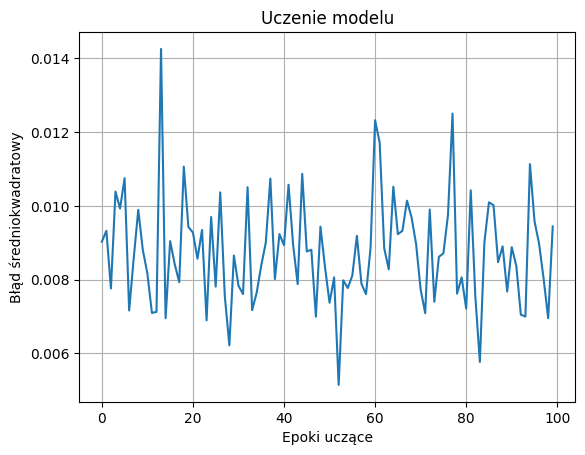

In [17]:
num_epochs = 100
all_losses = []
model.train()

for epoch in range(num_epochs):
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        x, y = x.reshape(-1, 4).to(device), y.reshape(-1, 1).to(device)
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
    all_losses.append(loss.item())
    print(f'Epoch: [{epoch+1}/{num_epochs}], loss: {loss.item():.6f}')

plt.plot(all_losses)
# plt.yscale('log')
plt.title('Uczenie modelu')
plt.xlabel('Epoki uczące')
plt.ylabel('Błąd średniokwadratowy')
plt.grid()
plt.show()

Train error: 0.008712678467418527
Test error: 0.010233688566032571


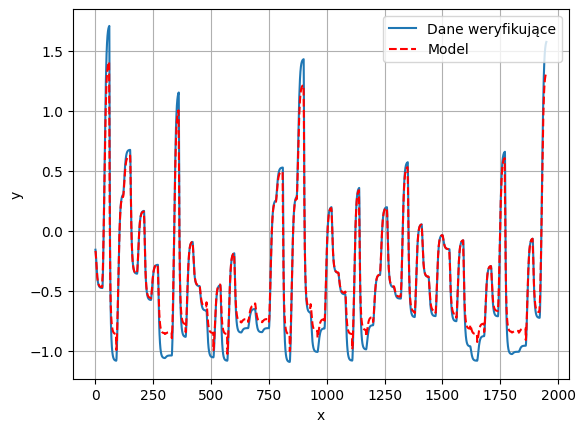

In [18]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 4).to(device))-trainset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 4).to(device))-testset[:][1].reshape(-1, 1).to(device)).reshape(-1).pow(2).mean()}')
plt.plot(y_test)
plt.plot(model(torch.tensor(x_test).reshape(-1, 4).to(device)).cpu().detach().numpy(), 'r--')
plt.legend(['Dane weryfikujące', 'Model'], loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

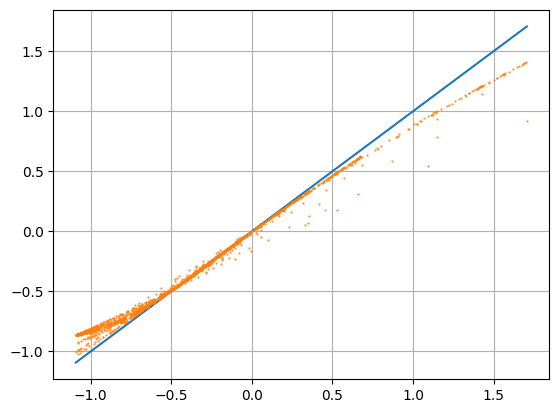

In [19]:
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)])
plt.plot(y_test, model(torch.tensor(x_test).reshape(-1, 4).to(device)).cpu().detach().numpy(), '.', markersize=1)
plt.grid()
plt.show()